In [2]:
%matplotlib inline
import os
import argparse
import logging
import time
import numpy as np
import numpy.random as npr
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [3]:
from torchdiffeq import odeint

In [4]:
rands = np.loadtxt("latent_ode_data/1kx1k_randn.csv", delimiter=",")

In [144]:
def createWeight(dims):
    sz = np.prod(dims)
    w = torch.from_numpy(rands[:sz].reshape(dims, order="F")).float()
    return torch.nn.Parameter(w)

class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=4, nhidden=20):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0
        with torch.no_grad():
            self.fc1.weight = createWeight(self.fc1.weight.shape)
            self.fc2.weight = createWeight(self.fc2.weight.shape)
            self.fc3.weight = createWeight(self.fc3.weight.shape)

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        return out


class RecognitionRNN(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=25, nbatch=1):
        super(RecognitionRNN, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.h2o = nn.Linear(nhidden, latent_dim * 2)
        with torch.no_grad():
            self.i2h.weight = createWeight(self.i2h.weight.shape)
            self.h2o.weight = createWeight(self.h2o.weight.shape)
            print(self.h2o.weight)

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h = torch.tanh(self.i2h(combined))
        out = self.h2o(h)
        return out, h

    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)
    
    def resetWeights(self):
        with torch.no_grad():
            self.i2h.weight = createWeight(self.i2h.weight.shape)
            self.h2o.weight = createWeight(self.h2o.weight.shape)
            self.i2h.bias = torch.nn.init.zeros_(self.i2h.bias)
            self.h2o.bias = torch.nn.init.zeros_(self.h2o.bias)


class Decoder(nn.Module):

    def __init__(self, latent_dim=4, obs_dim=2, nhidden=20):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)
        with torch.no_grad():
            self.fc1.weight = createWeight(self.fc1.weight.shape)
            self.fc2.weight = createWeight(self.fc2.weight.shape)

    def forward(self, z):
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
        return out


class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val


def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device)
    const = torch.log(const)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))


def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl


latent_dim = 4
nhidden = 20
rnn_nhidden = 25
obs_dim = 2
nspiral = 1000
start = 0.
stop = 6 * np.pi
noise_std = .3
a = 0.
b = .3
ntotal = 500
nsample = 100
device = torch.device('cuda:' + str(0) if torch.cuda.is_available() else 'cpu')

# model
lr = 0.01
func = LatentODEfunc(latent_dim, nhidden).to(device)
rec = RecognitionRNN(latent_dim, obs_dim, rnn_nhidden, nspiral).to(device)
dec = Decoder(latent_dim, obs_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
optimizer = optim.Adam(params, lr=lr)
loss_meter = RunningAverageMeter()

Parameter containing:
tensor([[ 0.8502,  0.4838,  1.2441, -0.4602,  0.2365, -0.2285, -0.2799, -1.9022,
         -0.4218, -0.6100, -0.0354, -0.4674, -0.5142,  0.8735, -0.5945,  0.1625,
          1.2139,  0.2140,  0.6137,  0.0680, -0.7405,  0.0119,  0.5295, -1.0595,
         -0.5860],
        [ 0.6706,  0.9485,  1.2818,  0.9213, -0.0313, -0.2500, -0.5638,  0.0655,
          1.5040,  0.9391, -0.4402, -0.0379,  0.2842, -0.7398, -0.8066, -1.3970,
          0.7393,  0.1484,  0.9215, -2.1960,  0.0408, -0.2132, -0.3089,  1.0187,
         -2.3004],
        [-0.4815,  0.6757,  1.1007, -2.4115,  0.6168, -0.2013, -0.9690, -1.6505,
         -1.1048,  0.4376,  0.9912,  1.6375,  1.5713, -0.9893, -0.2838, -0.6637,
         -0.4571, -0.5677, -0.5546,  0.6735, -0.6598,  1.1995,  0.2044, -0.5047,
         -1.1320],
        [ 1.3690,  0.6802,  0.6855, -0.2710, -0.4110, -0.9030,  0.7594,  0.6402,
          1.0845,  0.2586, -0.3792,  0.0118, -0.3956, -0.5196, -1.0876,  1.9097,
          0.3442,  1.0456,  1.

In [145]:
orig_trajs = np.loadtxt("latent_ode_data/orig_trajs.csv", delimiter=",").reshape((nspiral, 500, 2), order="F")
samp_trajs = np.loadtxt("latent_ode_data/samp_trajs.csv", delimiter=",").reshape((nspiral, nsample, 2), order="F")
orig_ts = np.loadtxt("latent_ode_data/orig_ts.csv", delimiter=",")
samp_ts = np.loadtxt("latent_ode_data/samp_ts.csv", delimiter=",")

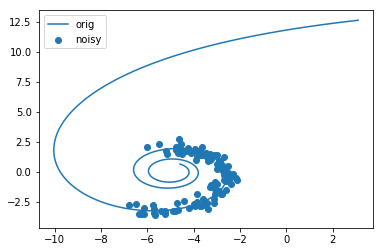

In [146]:
plt.figure()
plt.plot(orig_trajs[1, :, 0], orig_trajs[1, :, 1], label='orig')
plt.scatter(samp_trajs[1, :, 0], samp_trajs[1, :, 1], label='noisy')
plt.legend()
plt.show()

In [147]:
orig_trajs = torch.from_numpy(orig_trajs).float().to(device)
samp_trajs = torch.from_numpy(samp_trajs).float().to(device)
samp_ts = torch.from_numpy(samp_ts).float().to(device)

In [166]:
optimizer.zero_grad()
# backward in time to infer q(z_0)
h = rec.initHidden().to(device)
rec.resetWeights()
#for t in reversed(range(samp_trajs.size(1))):
for t in reversed(range(78,samp_trajs.size(1))):
    obs = samp_trajs[:, t, :]
    out, h = rec.forward(obs, h)
print(out)
print(h)

tensor([[ -2.1573,   2.0143,  -3.0909,  ...,   1.4557,   4.8459,  -0.6020],
        [  1.9842,   2.0966,   3.1563,  ...,  -4.3384,  -5.1562,   3.8471],
        [ -3.6158,   1.2643, -10.0299,  ...,   3.7081,   7.9673,   1.8052],
        ...,
        [ -2.1754,   2.6222,  -2.8869,  ...,  -2.0467,   0.7350,  -5.4856],
        [  2.6186,   3.7974,   5.8671,  ...,   3.5860,  -5.2105,   1.9873],
        [ -2.0170,   2.1934,  -2.8682,  ...,   1.5951,   4.5869,  -0.5580]],
       grad_fn=<AddmmBackward>)
tensor([[ 0.9909,  1.0000, -0.5268,  ..., -1.0000,  1.0000,  0.9991],
        [-0.9999,  1.0000,  0.7887,  ...,  0.9998, -1.0000, -0.9999],
        [ 0.7689, -0.1392, -1.0000,  ..., -0.9998,  0.7615,  0.7874],
        ...,
        [-0.4072,  1.0000,  0.0038,  ..., -1.0000,  1.0000,  1.0000],
        [ 0.9956, -0.8954,  0.5917,  ...,  1.0000, -0.9952, -0.9999],
        [ 0.8936,  1.0000, -0.3898,  ..., -1.0000,  1.0000,  0.9998]],
       grad_fn=<TanhBackward>)


In [137]:
qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
size = np.prod(qz0_mean.size())
epsilon = torch.from_numpy(rands[:size].reshape(qz0_mean.size())).float().to(device)
print(epsilon)
z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean
print(z0.size())
print(z0)

tensor([[ 0.8502,  0.6706, -0.4815,  1.3690],
        [ 1.8075,  1.9676, -0.2883,  1.8798],
        [ 0.4838,  0.9485,  0.6757,  0.6802],
        ...,
        [ 0.3667, -0.1572, -1.7548, -2.1620],
        [ 0.0802,  1.0119, -0.2121,  0.1846],
        [-0.3075, -1.1857,  0.7423, -0.6946]])
torch.Size([1000, 4])
tensor([[ 1.1653e+01, -1.3358e-01, -9.2657e+01,  4.5983e+00],
        [ 1.5594e+00, -9.0651e-01,  1.7379e-01, -8.1175e+00],
        [ 6.4389e-01,  1.4524e+01,  3.7540e-01,  1.5148e+01],
        ...,
        [ 8.3479e-01, -3.0816e+00, -1.4265e+01,  9.3842e+00],
        [ 2.2802e+00, -1.3982e+00,  3.2000e+00, -1.0460e+01],
        [-2.4006e+00, -3.8584e+00,  5.0047e+03,  8.0376e-02]],
       grad_fn=<AddBackward0>)
